In [1]:
import torch
from torch import nn
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import requests
import json
from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method


# GRADIENT BASED PIXEL ATTRIBUTION

### Utility functions

In [2]:
model = models.vgg16(pretrained=True)
model.eval()

/Users/homemac/miniconda3/envs/test/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/homemac/miniconda3/envs/test/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [3]:
# Load ImageNet Class Index and create idx2label
imagenet_class_index_url = 'https://storage.googleapis.com/download.tensorflow.org/data/imagenet_class_index.json'
class_idx = json.loads(requests.get(imagenet_class_index_url).text)
idx2label = [class_idx[str(k)][1] for k in range(len(class_idx))]

In [4]:
def preprocess_image(img_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ])
    image = Image.open(img_path).convert('RGB')
    image = transform(image).unsqueeze(0)
    return image

In [5]:
def predict_image(model, image):
    output = model(image)
    _, preds = torch.max(output, 1)
    return preds.item()

def print_predicted_class(model, image):
    pred_class = predict_image(model, image)
    print(f"Predicted Class: {idx2label[pred_class]} ({pred_class})")
    return pred_class

In [6]:
def display_heatmap(image_path, heatmap, alpha=0.5):
    img = Image.open(image_path)
    img = img.resize((224, 224))
    heatmap = Image.fromarray(np.uint8(255 * heatmap))
    heatmap = heatmap.resize(img.size)
    heatmap = np.asarray(heatmap)
    plt.imshow(img)
    plt.imshow(heatmap, cmap='jet', alpha=alpha)
    plt.show()

In [7]:
image_paths = [
    './images/lion.jpg',
    './images/beagle.jpg',
    './images/airliner.jpg',
    './images/banana.jpg',
    './images/coffeemug.jpg',
    './images/volcano.jpg'
]

## GRAD-CAM

In [8]:
class VGG16GradCAM(nn.Module):
    def __init__(self, pretrained_model):
        super().__init__()
        self.features = pretrained_model.features
        self.avgpool = pretrained_model.avgpool
        self.classifier = pretrained_model.classifier
        self.gradients = None

    def activations_hook(self, grad):
        self.gradients = grad

    def forward(self, x):
        x = self.features(x)
        # Register hook to capture gradients
        h = x.register_hook(self.activations_hook)
        x = self.avgpool(x)
        x = x.view((x.size(0), -1))
        x = self.classifier(x)
        return x

    def get_activations_gradient(self):
        return self.gradients

    def get_activations(self, x):
        return self.features(x)


In [9]:
def grad_cam(model, image, target_class):
    model_output = model(image)
    model.zero_grad()
    one_hot_output = torch.FloatTensor(1, model_output.size()[-1]).zero_()
    one_hot_output[0][target_class] = 1
    model_output.backward(gradient=one_hot_output)

    gradients = model.get_activations_gradient()
    pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
    activations = model.get_activations(image).detach()

    for i in range(activations.shape[1]):
        activations[:, i, :, :] *= pooled_gradients[i]

    heatmap = torch.mean(activations, dim=1).squeeze()
    heatmap = np.maximum(heatmap, 0)
    heatmap /= torch.max(heatmap)
    return heatmap.numpy()

Predicted Class: lion (291)


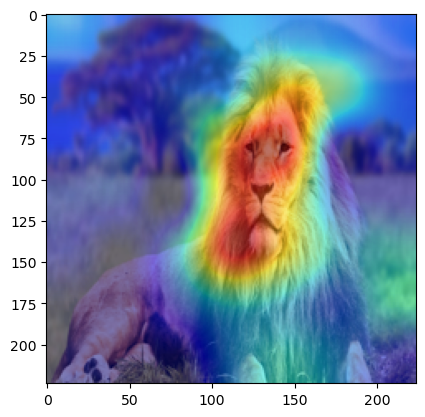

Predicted Class: beagle (162)


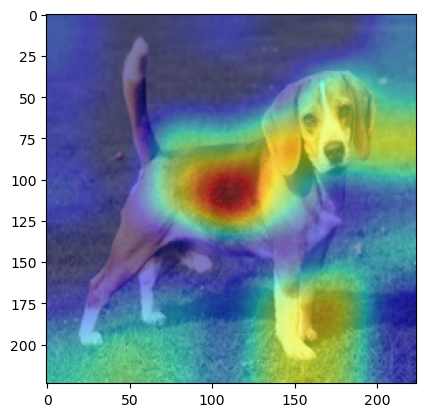

Predicted Class: airliner (404)


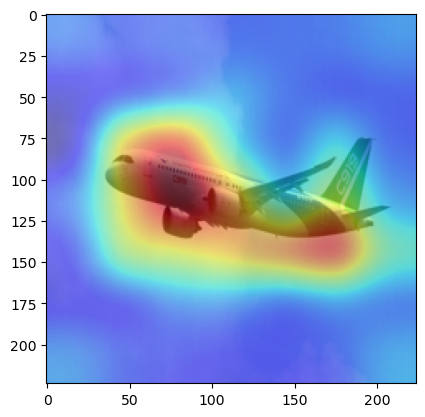

Predicted Class: banana (954)


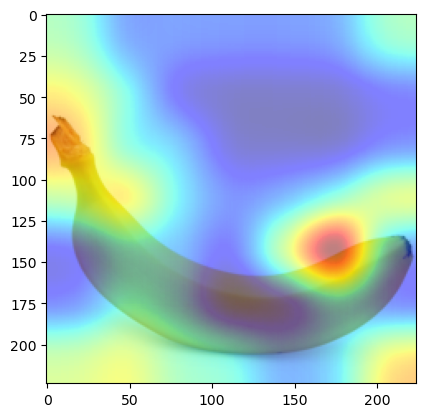

Predicted Class: coffee_mug (504)


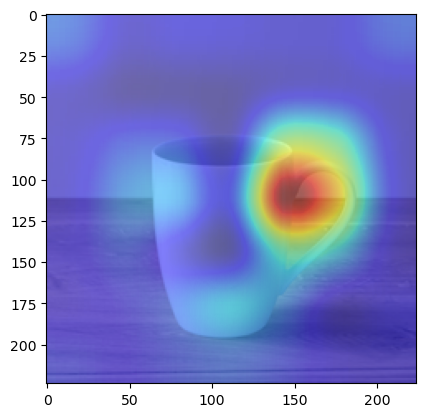

Predicted Class: volcano (980)


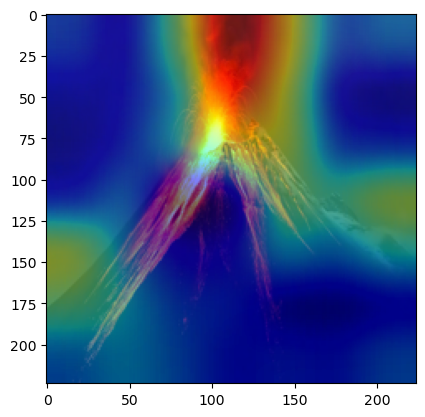

In [10]:
for image_path in image_paths:
    image = preprocess_image(image_path)
    cam_model = VGG16GradCAM(model)

    # Predict the class
    pred_class = predict_image(model, image)
    print_predicted_class(model, image)

    heatmap = grad_cam(cam_model, image, pred_class)
    display_heatmap(image_path, heatmap)

## Guided backpropagation

In [11]:
class VGG16GuidedBackprop(nn.Module):
    def __init__(self, pretrained_model):
        super().__init__()
        self.model = pretrained_model
        self.model.eval()
        # Override ReLU layers
        for module in self.model.modules():
            if isinstance(module, nn.ReLU):
                module.register_backward_hook(self.relu_backward_hook)

    def relu_backward_hook(self, module, grad_in, grad_out):
        """
        If there is a negative gradient, changes it to zero
        """
        if isinstance(module, nn.ReLU):
            return (torch.clamp(grad_in[0], min=0.0),)

    def forward(self, x):
        return self.model(x)

    def generate_gradients(self, input_image, target_class):
        input_image.grad = None  # Ensure gradients are reset
        model_output = self.forward(input_image)
        self.model.zero_grad()
        one_hot_output = torch.zeros_like(model_output)
        one_hot_output[0, target_class] = 1
        model_output.backward(gradient=one_hot_output)
        return input_image.grad  # Make sure it returns the gradient of the input


guided_bp_model = VGG16GuidedBackprop(model)

In [12]:
def display_saliency(image_path, saliency):
    saliency = saliency.squeeze()  # Remove batch dimension if present
    img = Image.open(image_path)
    img = img.resize((224, 224))
    saliency = np.abs(saliency).max(axis=0)  # Collapse channel dimension

    plt.imshow(img)
    plt.imshow(saliency, cmap='hot', alpha=0.5)
    plt.axis('off')
    plt.show()

/Users/homemac/miniconda3/envs/test/lib/python3.10/site-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


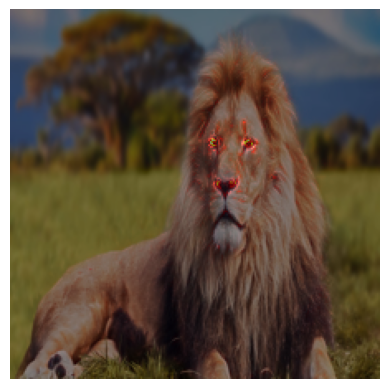

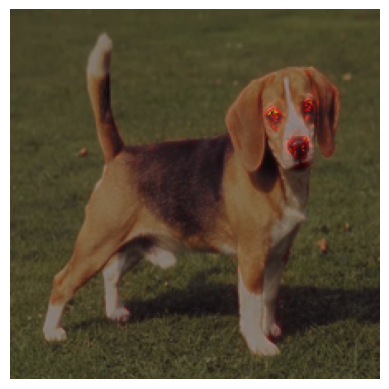

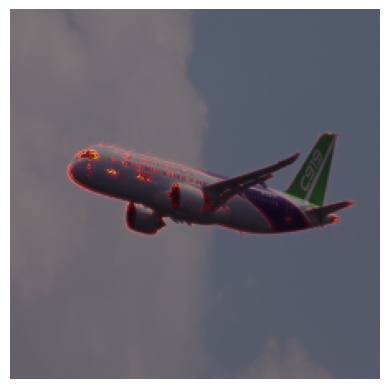

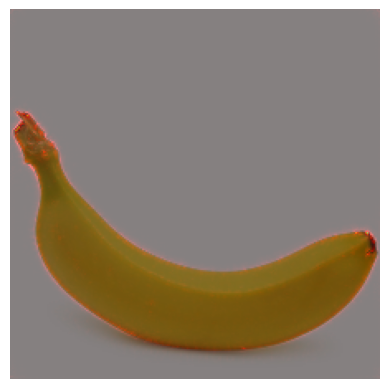

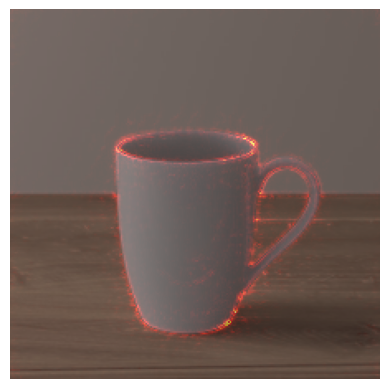

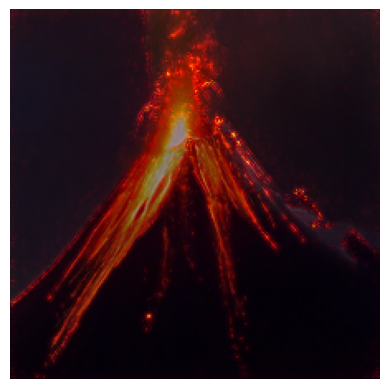

In [13]:
for image_path in image_paths:
    image = preprocess_image(image_path)
    image.requires_grad = True
    pred_class = predict_image(model, image)
    
    saliency = guided_bp_model.generate_gradients(image, pred_class)
    if saliency is not None:
        saliency = saliency.cpu().numpy()  # Move tensor to CPU and convert to NumPy
        display_saliency(image_path, saliency)
    else:
        print("No gradients were calculated.")

## Guided GRAD-CAM

In [14]:
def guided_grad_cam(grad_cam_heatmap, guided_backprop_grads):
    # Ensure guided_backprop_grads is in numpy format and has no extra dimensions
    guided_backprop_grads = guided_backprop_grads.squeeze().numpy()

    # Resize the heatmap to match the dimensions of the guided backpropagation gradients
    # Assuming the heatmap shape is (1, height, width) or (height, width)
    heatmap_resized = np.array(Image.fromarray(grad_cam_heatmap.squeeze()).resize(
        guided_backprop_grads.shape[1:], Image.BILINEAR))

    # Ensure the heatmap is expanded back to match the dimensions for broadcasting
    heatmap_expanded = np.expand_dims(heatmap_resized, axis=0)

    # Element-wise multiplication
    cam_gb = np.multiply(guided_backprop_grads, heatmap_expanded)
    
    # Normalize to range 0-1 for better visualization
    cam_gb -= cam_gb.min()
    cam_gb /= cam_gb.max()
    
    return cam_gb

In [15]:
def display_guided_grad_cam(image_path, cam_gb):
    img = Image.open(image_path)
    img = img.resize((224, 224))
    
    plt.imshow(cam_gb[0], cmap='hot', alpha=0.5)
    plt.axis('off')
    plt.show()

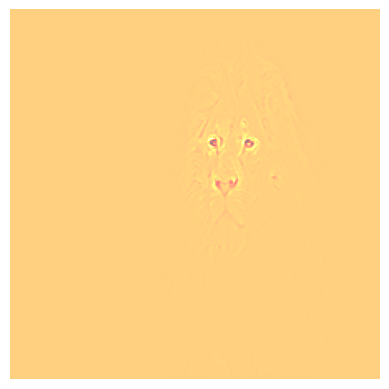

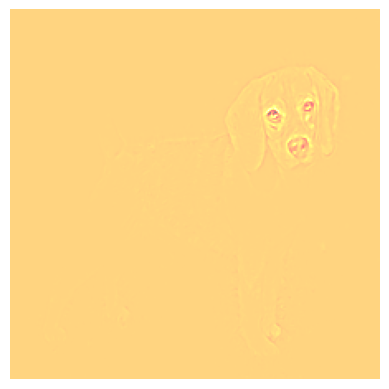

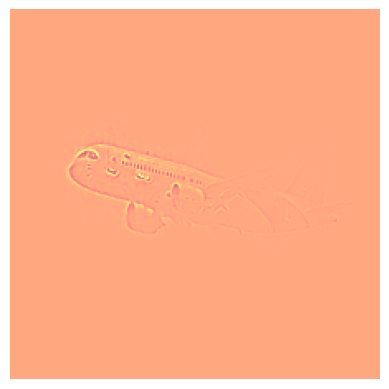

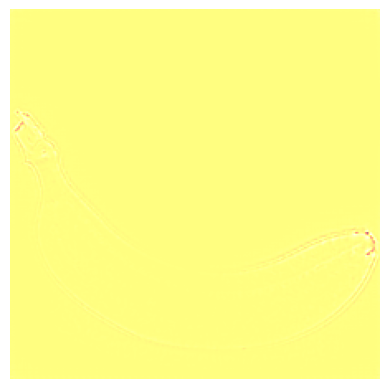

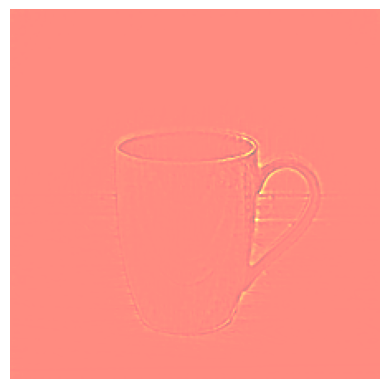

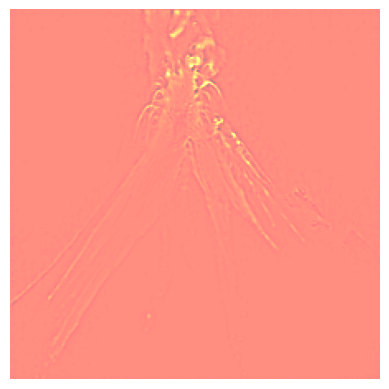

In [16]:
for image_path in image_paths:
    image = preprocess_image(image_path)
    image.requires_grad = True

    # Get predictions and heatmaps for Grad-CAM
    cam_model = VGG16GradCAM(model)
    pred_class = predict_image(model, image)
    heatmap = grad_cam(cam_model, image, pred_class)

    # Get gradients for Guided Backpropagation
    guided_bp_model = VGG16GuidedBackprop(model)
    guided_grads = guided_bp_model.generate_gradients(image, pred_class)

    # Combine both techniques to get Guided Grad-CAM
    cam_gb = guided_grad_cam(heatmap, guided_grads)
    
    # Display results
    display_guided_grad_cam(image_path, cam_gb)

## Guided backpropagation + SmoothGrad

In [17]:
# SmoothGrad Guided-Backpropagation
class VGG16GuidedBackpropSmoothGrad(nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.model.eval()
        for module in self.model.modules():
            if isinstance(module, torch.nn.ReLU):
                module.register_backward_hook(self.relu_backward_hook)

    def relu_backward_hook(self, module, grad_in, grad_out):
        return (torch.clamp(grad_in[0], min=0.0),)

    def forward(self, x):
        return self.model(x)

    def generate_smooth_grad(self, input_image, target_class, n_samples=50, noise_level=0.15):
        input_image.requires_grad = True
        smooth_grad = None

        for i in range(n_samples):
            noise = torch.randn(input_image.size()) * noise_level
            noisy_image = input_image + noise
            output = self.forward(noisy_image)
            self.model.zero_grad()
            one_hot_output = torch.zeros_like(output)
            one_hot_output[0, target_class] = 1
            output.backward(gradient=one_hot_output)
            grad = input_image.grad.data.clone()
            input_image.grad.data.zero_()

            if smooth_grad is None:
                smooth_grad = grad
            else:
                smooth_grad += grad

        smooth_grad /= n_samples
        return smooth_grad

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


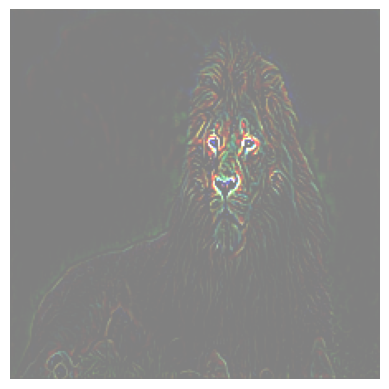

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


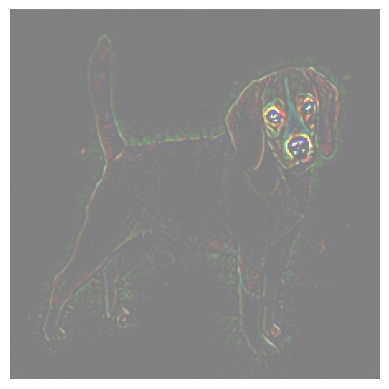

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


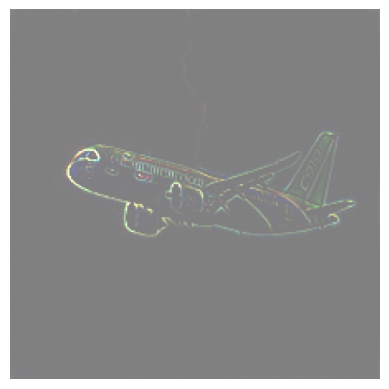

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


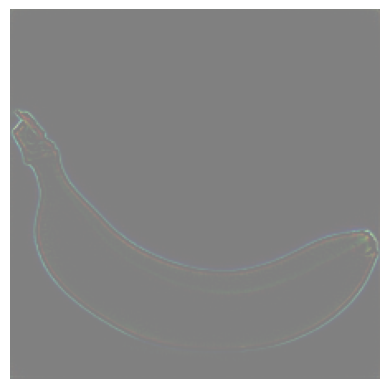

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


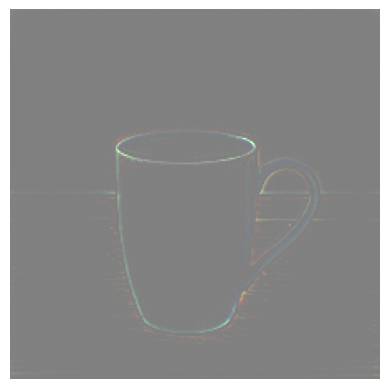

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


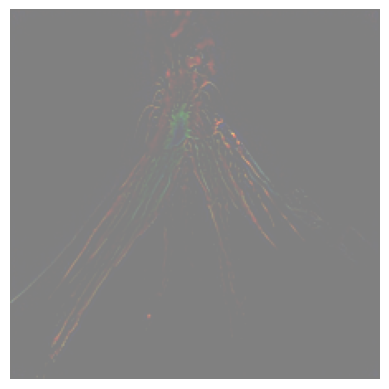

In [18]:
# Display function adjusted for direct use with tensors
def display_saliency(image_path, saliency):
    img = Image.open(image_path)
    img = img.resize((224, 224))
    # plt.imshow(img)
    plt.imshow(saliency, cmap='hot', alpha=0.5)
    plt.axis('off')
    plt.show()

# Using the existing VGG16GuidedBackpropSmoothGrad class
gb_smooth_model = VGG16GuidedBackpropSmoothGrad(model)

for image_path in image_paths:
    image = preprocess_image(image_path)
    pred_class = predict_image(model, image)
    smooth_grad = gb_smooth_model.generate_smooth_grad(image, pred_class)
    
    # Convert tensor to numpy array and remove unnecessary dimensions
    smooth_grad_np = smooth_grad.squeeze().cpu().numpy()
    smooth_grad_np = np.transpose(smooth_grad_np, (1, 2, 0))
    display_saliency(image_path, smooth_grad_np)

## Guided backpropagation + SmoothGrad + Grad-CAM

In [19]:
def combine_grad_cam_and_guided_bp(grad_cam_heatmap, guided_backprop_grads):
    # Ensure grad_cam_heatmap is 2D
    heatmap_resized = grad_cam_heatmap.squeeze()
    if len(heatmap_resized.shape) != 2:
        raise ValueError("Heatmap must be a 2D array.")

    # Convert heatmap to an image, resize it to match guided_backprop_grads dimensions, and convert back to array
    heatmap_image = Image.fromarray((heatmap_resized * 255).astype(np.uint8))  # Scale to [0, 255] and convert to uint8
    heatmap_resized = np.array(heatmap_image.resize(
        guided_backprop_grads.shape[:2], Image.BILINEAR))

    # Ensure heatmap is still 2D after resizing
    if len(heatmap_resized.shape) != 2:
        raise ValueError("Resized heatmap must be a 2D array.")

    # Element-wise multiplication
    combined_output = guided_backprop_grads * heatmap_resized[:, :, np.newaxis]  # Add an axis for broadcasting
    combined_output -= combined_output.min()
    combined_output /= combined_output.max()
    return combined_output

In [20]:
def display_combination(image_path, cam_gb):
    img = Image.open(image_path)
    img = img.resize((224, 224))
    
    # Ensure cam_gb is correctly shaped
    if len(cam_gb.shape) == 3:
        if cam_gb.shape[2] == 1:
            cam_gb = cam_gb.squeeze(axis=2)  # Remove the singleton dimension if necessary
        elif cam_gb.shape[2] == 3:
            # Convert to grayscale by averaging the channels
            cam_gb = np.mean(cam_gb, axis=2)
        else:
            raise ValueError("cam_gb must have 1 or 3 channels in the third dimension.")
    elif len(cam_gb.shape) != 2:
        raise ValueError("cam_gb must be a 2D array or a 3D array with the last dimension being 1 or 3.")

    # plt.imshow(np.array(img))
    plt.imshow(cam_gb, cmap='hot', alpha=0.5)  # Ensure the heatmap uses a transparency of 50%
    plt.axis('off')  # Turn off axis labels
    plt.show()

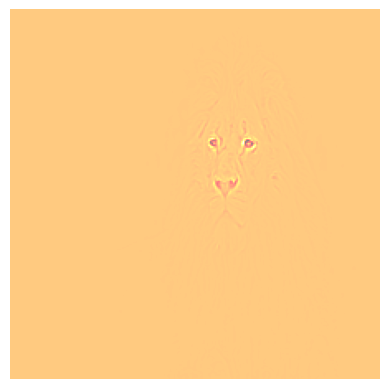

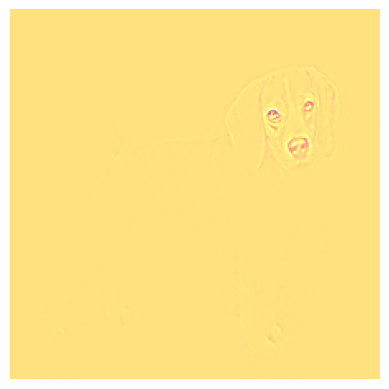

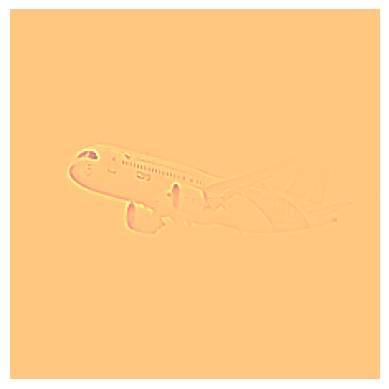

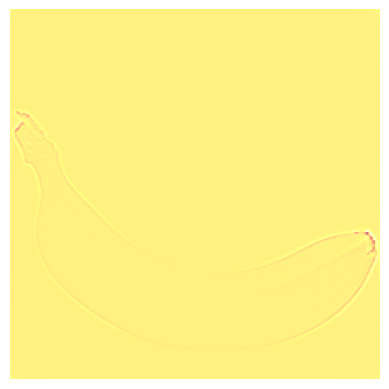

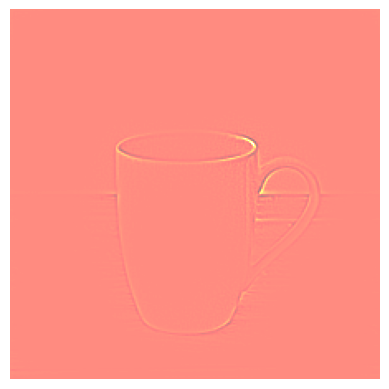

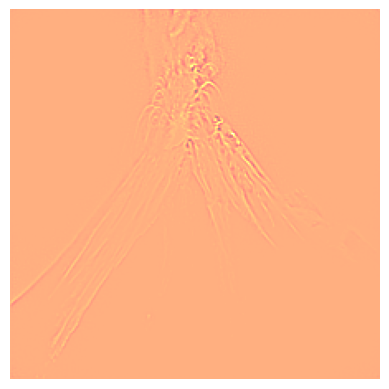

In [21]:
for image_path in image_paths:
    image = preprocess_image(image_path)
    pred_class = predict_image(model, image)

    # Grad-CAM
    cam_model = VGG16GradCAM(model)
    grad_cam_heatmap = grad_cam(cam_model, image, pred_class)
    # Guided Backprop Smooth Grad
    gb_smooth_model = VGG16GuidedBackpropSmoothGrad(model)
    guided_grad = gb_smooth_model.generate_smooth_grad(image, pred_class)

    # Convert tensor to numpy for processing
    guided_grad_np = guided_grad.squeeze().cpu().numpy()
    guided_grad_np = np.transpose(guided_grad_np, (1, 2, 0))

    # Combine the outputs
    combined_output = combine_grad_cam_and_guided_bp(grad_cam_heatmap, guided_grad_np)
    
    display_combination(image_path, combined_output)

## Adversarial Petrebution and Pixel Attribiution

Before attack:
Predicted Class: lion (291)
After attack:
Predicted Class: Irish_setter (213)


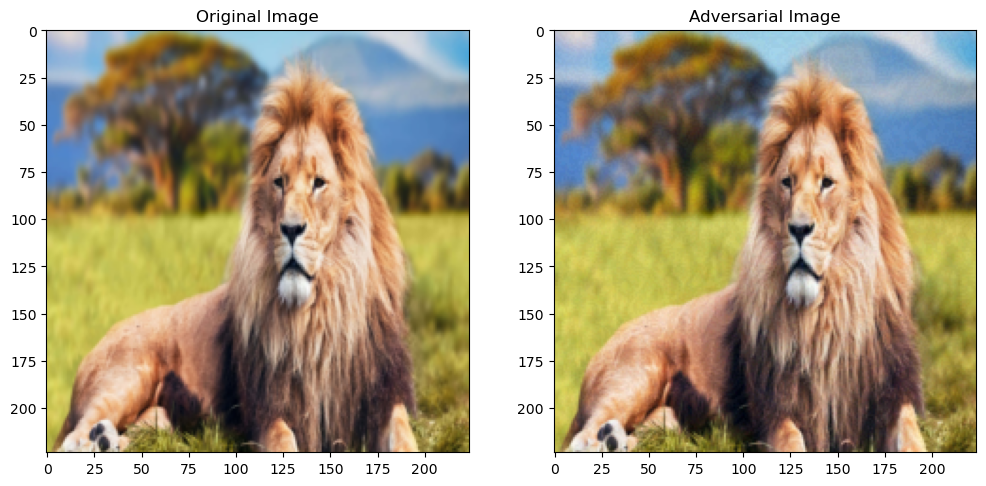

In [40]:
# Function to visualize images
def imshow(img, title=None):
    img = img.detach().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title is not None:
        plt.title(title)


# Load and preprocess your image
image_path = './images/lion.jpg'  # Update this path to your image
input_tensor = preprocess_image(image_path)

# Predict the class and print it using the updated function
print("Before attack:")
pred_class = print_predicted_class(model, input_tensor)

# Generate Adversarial Example Using FGSM
epsilon = 0.05  # Perturbation level
adv_tensor = fast_gradient_method(model, input_tensor, epsilon, np.inf, targeted=False)

# Predict and print class after the attack using the updated function
print("After attack:")
adv_pred_class = print_predicted_class(model, adv_tensor)


# Visualize the Original and Adversarial Images
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
imshow(input_tensor[0], title='Original Image')
plt.subplot(1, 2, 2)
imshow(adv_tensor[0], title='Adversarial Image')
plt.show()

/Users/homemac/miniconda3/envs/test/lib/python3.10/site-packages/torch/nn/modules/module.py:1373: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


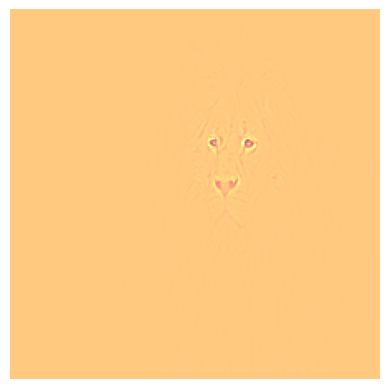

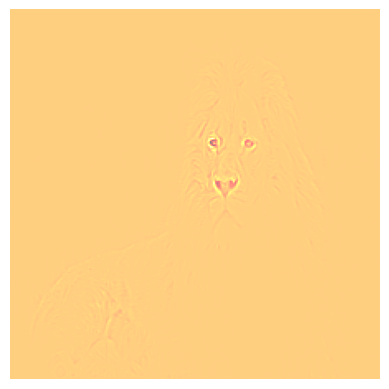

In [36]:
# Assuming grad_cam and generate_smooth_grad are defined correctly elsewhere
def process_and_display(input_tensor, pred_class, image_path):
    # Create a leaf tensor with requires_grad enabled
    input_tensor_leaf = input_tensor.clone().detach()
    input_tensor_leaf.requires_grad = True

    # Grad-CAM
    grad_cam_heatmap = grad_cam(cam_model, input_tensor_leaf, pred_class)
    
    # Guided Backprop Smooth Grad
    guided_grad = gb_smooth_model.generate_smooth_grad(input_tensor_leaf, pred_class)

    # Convert tensor to numpy for processing
    guided_grad_np = guided_grad.squeeze().cpu().numpy()
    guided_grad_np = np.transpose(guided_grad_np, (1, 2, 0))

    # Combine the outputs
    combined_output = combine_grad_cam_and_guided_bp(grad_cam_heatmap, guided_grad_np)

    # Display combined visualizations
    display_combination(image_path, combined_output)

# Example usage
process_and_display(input_tensor, pred_class, image_path)
process_and_display(adv_tensor, adv_pred_class, image_path)